# Nonlinear Regression in [`SciPy`](https://docs.scipy.org/doc/scipy/reference/) and [R](https://www.r-project.org/about.html)

We often need to find a function $y=f(x,\beta)$ of variable $x$ and $p$ unknown parameters $\beta$ which fits a given set of $n$ predictor, {$x_1,...,x_n$}, and response, {$y_1,...,y_n$}, values.<br>
The best fit can be obtained by minimizing the residual sums of squares (RSS) with respect to $\beta$,
\begin{equation}
\mathrm{RSS}(\beta) = \sum_{n=1}^{\infty} \left[ y_i - f(x_i,\beta) \right ] ^2.
\end{equation}
For nonlinear functions, numerical optimization methods are needed to minimize RSS and find the best-fit parameters, $\hat{\beta}$.<br>
The most common numerical optimization method for nonlinear regression is the [Gauss-Newton method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm).<br>
The assumption in nonlinear regression is that the measurement errors are standard normally distributed.<br>
A summary measure of the model fit is the residual variance which is defined as the ratio of the minimum of RSS devided by the number of degrees of freedom:
\begin{equation}
\chi_R^2 = \frac{\mathrm{RSS}(\hat{\beta})}{n-p}.
\end{equation}
Sometimes, we have several curves that we want to fit with the same function $f$. These curves have some parameters in common that we want to be determined on all the available data.<br>
In this Notebook, we show how to perform least-sqares fits in `scipy` and `R`.

In [1]:
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': [3.5, 3], 'font.size':8, 'legend.fontsize':8, 'figure.dpi': 150,
                     'legend.handlelength':1, 'legend.frameon':False,
                     'xtick.major.size':6,'ytick.major.size':6,
                     'xtick.minor.size':3,'ytick.minor.size':3,
                     'xtick.direction':'out','ytick.direction':'out',
                     'xtick.labelsize':8,'ytick.labelsize':8,
                     'xtick.major.pad':2,'ytick.major.pad':2,
                     'axes.linewidth':1,'axes.labelsize':10,})
from cryptography.fernet import Fernet
import base64
def encrypt(string, key):
    keygen = lambda x : base64.urlsafe_b64encode(x.encode() + b' '*(32 - len(x)))
    cipher = Fernet(keygen(key))
    return cipher.encrypt(string.encode())
def decrypt(string, key):
    keygen = lambda x : base64.urlsafe_b64encode(x.encode() + b' '*(32 - len(x)))
    cipher = Fernet(keygen(key))
    return print(cipher.decrypt(string.encode()).decode())

/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Case Study: Time-Resolved Fluorescence Spectroscopy

### SDS Micelles in the Presence of a Hydrophobic Fluorophore and a Fluorescence Quencher

- **The micelle:**<br>
    Sodium dodecyl sulfate (SDS) is an anionic surfactant with a hydrophobic tail of 12 carbon atoms and a hydrophilic sulphate head group. Due to its amphipatic nature, SDS self-assembles into micelles in aqueous solution. Micelle formation is a cooperative process which occurs in a narrow range of surfactant concentrations around the critical micellar concentration (CMC).<br>At concentrations below the CMC., surfactant molecules are mostly in the monomer state.<br>At the  (CMC), surfactant molecules form micelles with a well-defined aggregation number. The size distribution of the aggregates is rather narrow and depends on the relative dimensions of the head and tail groups.<br>Above the CMC, the number of micelles increases while the size of the micelles stays the same.  
<table><tr><td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Sodium_dodecyl_sulfate.svg/2880px-Sodium_dodecyl_sulfate.svg.png" width="300"></td><td><img src="https://marcello-sega.github.io/pytim/_images/micelle2.png" width="150"></td></tr><table>    
 
- **The fluorophore:**<br>Pyrene is a hydrophobic fluorescent molecule.<br>In an aqueous SDS solution at [SDS]>CMC, pyrene tends to partition into the hydrophobic interior of the micelles.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Pyrene.svg/190px-Pyrene.svg.png" width="150" align="center">

- **The quencher:**<br>Benzophenone is a hydrophobic compound which also tend to be in the micelles where it quenches the fluorescence of pyrene (it makes it decay faster). 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Benzophenon.svg/1200px-Benzophenon.svg.png" width="150" align="center">

- **The experiment:**
We measure the number of photons emitted by pyrene molecules in SDS micelles for increasing time intervals after the excitation pulse. The fluorescence intensity decay of pyrene following an excitation pulse is given by<br><br>
\begin{equation}
F(t)=F(0)\exp(-t/\tau_0)
\end{equation}<br>
where $\tau_0$ is the lifetime of the fluorophore.
In the presence of $j$ benzophenone molecules per micelle, the lifetime of pyrene decreases to
\begin{equation}
\tau_j = \frac{\tau_0}{1 + j k_q \tau_0}.
\end{equation}
where $k_q$ is the quenching constant.<br>
The distribution of quenchers in the micelles follows Poisson's statistics, therefore the fraction of micelles containing $j$ benzophenone molecules is given by
\begin{equation}
P(j) = \frac{m^j}{j!}\exp{(-m)}
\end{equation}
where $m$ is the average number of benzophenone molecules per micelle.<br>
The fluorescence intensity decay of pyrene in the presence of benzophenone is given by the weighted average over the difstribution of micelles with different numbers of quenchers<br><br>
\begin{equation}
F(t)=F(0)\sum_{j=0}^{\infty} P(j) \exp{(-t/\tau_j)}=F(0)\exp\left\{-t/\tau_0-m\left [1-\exp{(-k_qt)}\right ]\right\},
\end{equation}<br>
where we have used the converging series
\begin{equation}
\sum_{j=0}^{\infty} \frac{x^j}{j!} = \exp{(x)}.
\end{equation}

We used a solution 70 mM SDS and 10 $\mu$M pyrene in 5mM phosphate buffer at pH 7.4. The emission wavelength of the spectrometer is set to 391 nm, corresponding to the maximum fluorescence intensity for pyrene.
- First, we measure the intensity decay of the solution in the absence of quencher. A least-squares fit on this curve yields $F(0)$ and the pyrene lifetime, $\tau_0$. 
- Then, we measure intensity decays for increasing concentrations of benzophenone, _i.e._, $[$quencher$]$ $=$ 0.1, 0.2, 0.5, 1 e 1.5 mM.
We perform a global fit on these five curves. Each corve has a different average number of quencher molecules per micelle, $m$, and common parameters $F(0)$, $\tau_0$, and $k_q$. 

Since the excitation pulse occurs in a shorter time scale compared to the decay of the fluorescence signal, we disregard the width of the excitation pulse in our analysis. In the least-squares fitting procedures, we weight each photon count, $F(t)$, by its error which is simply $\sqrt{F(t)}$ because fluorescence counts follow Poisson's statistics.<br>

### The Data

The data are tab-separated values (TSV) files (collected at [Prof. L. Stella lab](http://www.stc.uniroma2.it/physchem/stella.html))

In [2]:
%cat 'data/fluorescence/quencher_0.0.txt'

Labels	quencher 0.0 mM	
Type	Time Scan	
Comment		
start(nm)	0.00	
stop(nm)	999.02340	
step(nm)	0.976563	
fixed/offset(nm)	 	
Xaxis	Time	
Yaxis	Counts	
0.00	1.000E+0	
0.976563	1.000E+0	
1.953125	0.000E+0	
2.929688	0.000E+0	
3.906250	1.000E+0	
4.882813	0.000E+0	
5.859375	0.000E+0	
6.835938	0.000E+0	
7.81250	0.000E+0	
8.789063	2.000E+0	
9.765625	1.000E+0	
10.742188	0.000E+0	
11.718750	0.000E+0	
12.695313	0.000E+0	
13.671875	1.000E+0	
14.648438	0.000E+0	
15.6250	0.000E+0	
16.601563	0.000E+0	
17.578125	2.000E+0	
18.554688	1.000E+0	
19.531250	0.000E+0	
20.507813	0.000E+0	
21.484375	1.000E+0	
22.460938	3.000E+0	
23.43750	0.000E+0	
24.414063	0.000E+0	
25.390625	0.000E+0	
26.367188	0.000E+0	
27.343750	1.000E+0	
28.320313	0.000E+0	
29.296875	2.000E+0	
30.273438	1.000E+0	
31.250	0.000E+0	
32.226563	1.000E+0	
33.203125	0.000E+0	
34.179688	0.000E+0	
35.156250	0.000E+0	
36.132813	0.000E+0	
37.109375	1.000E+0	
38.085938	0.000E+0	
39.06250	0.000E+0	
40.039063	0.000E+0	
41.015625	0.000E+0	
41.992188	0.

In [3]:
%ls 'data/fluorescence'

quencher_0.0.txt  quencher_0.5.txt  quencher_1.5.txt
quencher_0.2.txt  quencher_1.0.txt


Let's plot the intensity decays for increasing concentrations of quencher.<br>
The intensity signal decays faster with increasing concentration of benzophenone.

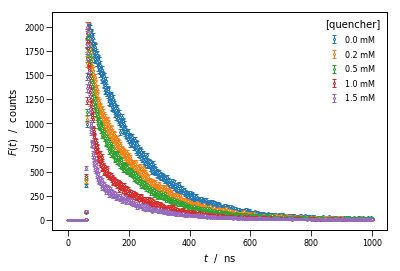

In [4]:
concs = [0.0,0.2,0.5,1.0,1.5]
for conc in concs:
    t,F = np.loadtxt('data/fluorescence/quencher_{:1.1f}.txt'.format(conc), unpack=True, skiprows=9)
    plt.errorbar(t, F, np.sqrt(F), lw=0, marker='o', label='{:1.1f}'.format(conc)+' mM',
                 ms=2, elinewidth=1., capsize=2, capthick=1., mfc='w')
plt.legend(title='[quencher]',labelspacing=.7,loc=1)
plt.ylabel('$F(t)$  /  counts'); plt.xlabel('$t$  /  ns'); 

Here, we use boolean masking to select the data points after the excitation pulse and we shift the x values so that they measure the time intervals from the excitation pulse.

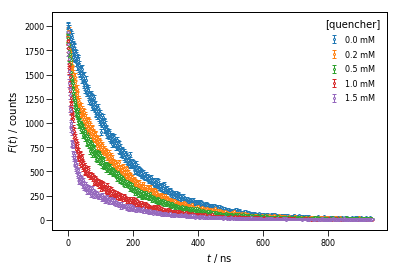

In [5]:
for conc in concs:
    d = np.loadtxt('data/fluorescence/quencher_{:1.1f}.txt'.format(conc), unpack=False, skiprows=9)
    d = d[ d[:,0] > d[d[:,1]==d[:,1].max(), 0] ] # points before the intesity max are discarded
    plt.errorbar(d[:,0]-d[0,0], d[:,1], np.sqrt(d[:,1]), lw=0, marker='o', label='{:1.1f}'.format(conc)+' mM',
                 ms=2, elinewidth=1., capsize=2, capthick=1., mfc='w')
plt.legend(title='[quencher]',labelspacing=.7)
plt.ylabel('$F(t)$ / counts'); plt.xlabel('$t$ / ns'); plt.show()

A convenient way to save data sets to file is to use [pickling](https://docs.python.org/3/library/pickle.html). We create a  `pandas` DataFrame and we save it as a binary file and also as a csv file.

In [6]:
data = pd.DataFrame()
for conc in concs:
    t,F = np.loadtxt('data/fluorescence/quencher_{:1.1f}.txt'.format(conc), unpack=True, skiprows=9)
    # points before the intesity max are discarded
    t = t[F.argmax():]
    F = F[F.argmax():]
    t = t - t[0] # t at the intesity max is t zero
    d = pd.DataFrame(data=np.c_[t,F,np.sqrt(F)],columns=['t','F','errF'])
    d['conc'] = conc
    d.set_index('conc',inplace=True)
    data = data.append(d)
data.to_pickle('data/fluorescence.p')
data.to_csv('data/fluorescence.csv')
data.head()

,t,F,errF
conc,,,
0.0,0.000000,2000.0,44.721360
0.0,0.976563,1995.0,44.665423
0.0,1.953125,1985.0,44.553339
0.0,2.929688,1968.0,44.362146
0.0,3.906250,1967.0,44.350874


The curve for $[$quencher$]$=0 mM is fitted to a single exponential decay function using [`optimize.least_square`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) which requires the following arguments:
- the function which computes the vector of residuals
- the initial parameters
- the data
- the lower and the upper bounds of the fitting parameters<br>

`
least_squares(function_to_minimize, initial_params, 
    [x, y, yerr], bounds=[(lower_bounds),(upper_bounds)])
`

`least_squares` returns an OptimizeResult object containig the best-fit parameters (`x`), the residuals calculated for the best-fit parameters (`fun`), RSS/2 (`cost`), and the modified Jacobian matrix, $J$, at the solution (`jac`), $J^T J$ is a [Gauss-Newton approximation of the Hessian](https://reference.wolfram.com/language/tutorial/UnconstrainedOptimizationGaussNewtonMethods.html) of the residual function.

Since we know that the error on the counts follows Poisson's distribution, we use the following [nonlinear regression model](https://link.springer.com/book/10.1007%2F978-0-387-09616-2)
\begin{equation}
y_i = f(x_i,\beta) + \frac{\epsilon_i}{\sqrt{w_i}},
\end{equation}
where the weight is the inverse of the error on the counts, $1 / \sqrt{y_i}$.<br>
We minimize, with respect to $\beta$, the residual sums of squares (RSS) weighted by $y_i$:
\begin{equation}
\mathrm{RSS}(\beta) = \sum_{n=1}^{\infty} \frac{\left[ y_i - f(x_i,\beta) \right ] ^2}{y_i}.
\end{equation}
For further details read chapter 6 of [Nonlinear Regression with R](https://link.springer.com/book/10.1007%2F978-0-387-09616-2) by Christian Ritz and Jens Carl Streibig.

In [7]:
# we define the exponential decay
def exp_decay(x, param):
    return param[0] * np.exp( - x / param[1] ) 

# we define the function that calculates the residuals
def residuals(param, *args):
    return ( args[1] - exp_decay(args[0], param) ) / args[2] # residuals weighted by the error on y

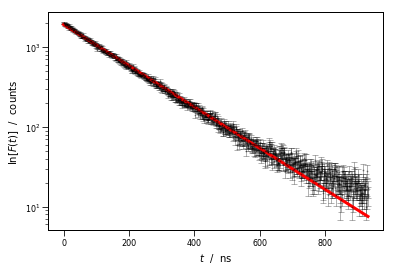

In [8]:
# we create a list with the data
args = [data.loc[0.0][col] for col in ['t','F','errF']]

# we fit the data
res = least_squares(residuals, x0=[3000,150], args=args, bounds=[(6,150),(3500,200)])

# we plot the data
plt.errorbar(args[0],args[1],args[2],lw=0,marker='o',ms=1,elinewidth=1.,capsize=3,capthick=1.,
             color='k',alpha=0.3)

# we plot the fitting curve
plt.plot(args[0],exp_decay(args[0],res['x']),lw=3,color='r')

# we set the log scale for the y-axis
plt.yscale('log')
plt.ylabel('$\ln [F(t)]$  /  counts'); plt.xlabel('$t$  /  ns'); 

In [9]:
print('Is one of the convergence criteria satisfied?', res.success) 

Is one of the convergence criteria satisfied? True


In [10]:
print('The best-fit parameters are',res.x[0],'and',res.x[1])

The best-fit parameters are 1915.416799350097 and 168.13658721264096


In [11]:
from IPython import display

table = r"""| Parameter     | Value         | Error |
| :---------------- |:-------------:| :----:|
| $F(0)$ (counts)   | %.2f          | ?     |
| $\tau_0$ (ns)     | %.2f          | ?     |"""

display.Markdown(table % tuple(res.x) )

| Parameter     | Value         | Error |
| :---------------- |:-------------:| :----:|
| $F(0)$ (counts)   | 1915.42          | ?     |
| $\tau_0$ (ns)     | 168.14          | ?     |

\begin{equation}
\chi_R^2 = \frac{\mathrm{RSS}(\hat{\beta})}{n-p}
\end{equation}

In [12]:
print('The residual variance is', 2 * res.cost / (res.fun.size - res.x.size))

The residual variance is 1.705759745226174


We can check whether the model is appropriate and we have obtained a good fit by comparing the Gaussian with $\sigma=1$ and $\mu=0$ with the histogram of the residuals at solution.<br>
We can see that the distribution of the residuals is compatible with a normal distribution. Would the comparison be this favorable if we didn't weight the error by the square root of the counts?

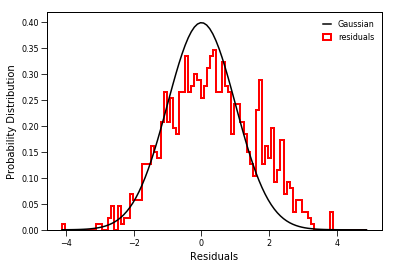

In [13]:
bins = np.linspace(res.fun.min(),res.fun.max()+1,100)
plt.plot(bins, np.exp(-bins*bins/2)/np.sqrt(2*np.pi), label='Gaussian', color='k')
plt.hist(res.fun, bins, lw=2, histtype='step', density=True, label='residuals', color='r')
plt.xlabel('Residuals'); plt.ylabel('Probability Distribution'); plt.legend();

The uncertainties on the best-fit parameters are estimated from the variance-covariance matrix.<br>
Here is the implementation in the function [`optimize.curve_fit`)](https://github.com/scipy/scipy/blob/2526df72e5d4ca8bad6e2f4b3cbdfbc33e805865/scipy/optimize/minpack.py#L739) which uses `least_squares` under the hood.
Further information [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) and [here](http://scipy-cookbook.readthedocs.io/items/FittingData.html).

In [14]:
from scipy.linalg import svd
# copied from curve_fit 
def error_analysis(res):
    rss = 2 * res.cost  # res.cost is half sum of squares!
    s_sq = rss / (res.fun.size - res.x.size) # residual variance or reduced chi squared
    # Do Moore-Penrose inverse discarding zero singular values.
    _, s, VT = svd(res.jac, full_matrices=False)
    threshold = np.finfo(float).eps * max(res.jac.shape) * s[0]
    s = s[s > threshold]
    VT = VT[:s.size]
    pcov = np.dot(VT.T / s**2, VT) * s_sq # variance-covariance matrix
    return np.sqrt(np.diag(pcov)), s_sq # errors on the params are the diagonal elements of pcov

In [15]:
table = r"""| Parameter     | Value         | Error |
| :---------------- |:-------------:| :----:|
| $F(0)$ (counts)   | %.0f          | %.0f  |
| $\tau_0$ (ns)     | %.1f          | %.1f  |"""

In [16]:
p_and_err = np.repeat(res.x, 2)
p_and_err[1::2] = error_analysis(res)[0]
print('Reduced chi squared:',error_analysis(res)[1])
display.Markdown(table % tuple(p_and_err) )

Reduced chi squared: 1.705759745226174


| Parameter     | Value         | Error |
| :---------------- |:-------------:| :----:|
| $F(0)$ (counts)   | 1915          | 6  |
| $\tau_0$ (ns)     | 168.1          | 0.4  |

##  Task 1
- Fit the data for $[$quencher$]$ $=$ 0 using [`optimize.curve_fit`)](https://github.com/scipy/scipy/blob/2526df72e5d4ca8bad6e2f4b3cbdfbc33e805865/scipy/optimize/minpack.py#L739).
- Plot the data and the function with the best-fit parameters.
- View a markdown table with the best-fit parameters and their uncertainties.

In [17]:
answer = 'gAAAAABcBDlaRCOfnjUcmToYnEdOciuqiLV8TVxoLmyI1YiwAU8Ux_kcXVgFb-AZ87LV3DggpValGCTdAZ3kfijtjcB-271i1d5gF-7tQzM_XqQpLoChhrOE31dym4nOheTkkMafgMtu5JTS2Xg2WD4ziYF1H4ri2E0zlV_yIdmbJ5X14f6caG3NFES5Y8FLuKBpJpuSYDoCOg3DsRH-_Lo3ZHpLHOe2iKNMyroVgdQ-W44SzRqucnkRv4bK0L3EUcBUHrW-fFhj6veqYTi464yVkNuLGQza0QzEGFvQu8QuBQMaggNw97dllsHpfSCoLh4sCwS6oe9IJLfxHBgusgwQnNcpahJcINmnFMQnRNsQn7bujSnRpEUeORZeQq2S_7OuKKZl2tpJrWtpyRrIophfTmf7fV7daORiXU2W9KAS0Ym0Kft10BfIp_XK7MsbDWHjc4CCj-U6SEx4Mn091ds8Qy-wHsTGxlAAnCLOY2irqVQYuYljzh7oq7iRWYk_sxGCddwSxMX2AsotclVz677gQWZHSHn-2lRVcL8xGQiattT2MicC0Gk2ukG2WdXs_cZHB3J7iBU2ZmMv00ZvYK7QWdEW-CCUhxKPb9daAhCURpXyatMKuZnP8KtCO8nJ9ITluNGFy-6dZ0FdplO9Y7wG7MHoXWJKoSlbXzMMZto5LK1AC_DLEM0ImzLyiQThwBFBpU0DuD1QRyEs4AzF1k3BS_ifpSZ-NXaF2j_pJneJkt7k64tEH7D1Ea9NsD1tLYmU2itKQwHh9BVdFRBJwYgBEoQ-oJAvh91gQxgJLi9gzU4I_kVEZnvnH-THrQ2xOAWdKsfCxXE5gBYNG5thCCsBllUUcB9h4jlVsuBCnx2u1hbrLq7glmWZOrfxUgMjvsYMi_6o5S0qW0XdFz0CjdPJ_E44CDSG30i-4XUE4z4AyrXsZP-8ViBY2vJmiGPNzLhiEv3c6URuS6Qns_EPvGwZQEnLDTeAtLY2owHeEva_gIGkT1U2-KK4CZXESBf9v0yv5ABptx3l_WhxqPIEzCbWvv9j_AU8f6-QT8eQR7a-akKrEaEqR9s_2LAAEN09nAmDHBcIJaKlfp-Zw00MG5UGBKERA4v1V74QoRNHunD3Cq-ZS8ckAiq9F3Tt4Hs0hLghSeujwLgsiQ95G8ktYKIyhnUxgXbwNdMcH5ulCEEgeeUVa6U3XadtVli3KUtKd3AaDGtlpoOZ9LqH6NSkI_mOk2BXiL9ZlVSM4hE_fz3gEt7fCJWd0VnxKGLiKuBNWsj7yc6dSZG6sdHwmVhGHmeY1pMXCN8lN-D3D1yOyzY5eYDtpkhGeJeNSC1Qbklx__ZuHUSbgX94g4tBL9XFnj4m6uSmfntk9KupnX3FWXV_oPVEyBbhEzU='


In [18]:
decrypt(answer,)

TypeError: decrypt() missing 1 required positional argument: 'key'

## Interfacing Python and [R](https://www.r-project.org/about.html)
We load the extension [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

In [19]:
%load_ext rpy2.ipython

/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/giulio/miniconda3/envs/LUcompute2/lib/python3.7/site-pack

In [20]:
X = args[0]
Y = args[1]
errY = args[2]

We send the data from Python to R

In [21]:
%Rpush X Y errY

We plot the data in R

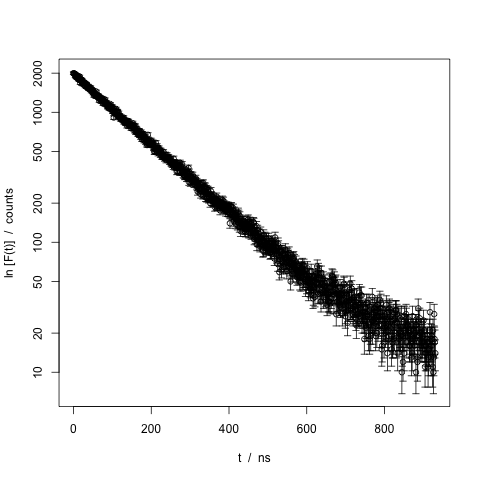

In [22]:
%%R
plot(X, Y, ylim = range(c(Y-errY, Y+errY)), xlab='t  /  ns', ylab='ln [F(t)]  /  counts', log='y')
arrows(X, Y-errY, X, Y+errY, length=0.05, angle=90, code=3)

We create a data frame in R

In [23]:
%%R
df <- data.frame('X' = X, 'Y' = Y)

We fit the data without weighting by the error

In [24]:
%%R
fit1 <- nls(Y ~ F0 * exp( - X / tau0 ), data=df, start = list(F0 = 2000, tau0 = 100))
summary(fit1)


Formula: Y ~ F0 * exp(-X/tau0)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
F0   1967.0350     2.9489   667.0   <2e-16 ***
tau0  162.5185     0.3457   470.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.13 on 952 degrees of freedom

Number of iterations to convergence: 4 
Achieved convergence tolerance: 7.61e-06



We weight by the error and we compare the results of the two approaches


Formula: Y ~ F0 * exp(-X/tau0)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
F0   1915.4171     6.3860   299.9   <2e-16 ***
tau0  168.1366     0.4201   400.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.306 on 952 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 3.486e-06



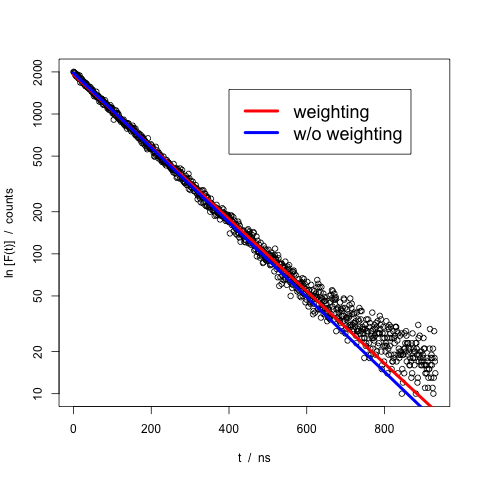

In [25]:
%%R
plot(Y ~ X, data=df, xlab='t  /  ns', ylab='ln [F(t)]  /  counts', log='y' )

fit2 <- nls(Y ~ F0 * exp( - X / tau0 ), data=df, start = list(F0 = 2000, tau0 = 100), weights=1/Y)

curve(predict(fit2, newdata = data.frame(X=x)), add=TRUE, lwd=4, col='red')

curve(predict(fit1, newdata = data.frame(X=x)), add=TRUE, lwd=4, col='blue')

legend(400, 1500, legend=c('weighting','w/o weighting'),
       col=c("red", "blue"), lwd=4, cex=1.5)

summary(fit2)

We calculate the residual variance

In [40]:
%%R
sum(residuals(fit2))/952

[1] 1.70576


## Global Least-Squares Fit

Now we performa a global fit of the 5 curves with increasing [quencher]: $F(0)$, $\tau_0$, and $k_q$ are global parameters whereas $m$ depends on [quencher].
* We create 3 lists (for x, y, and yerr) each containing 5 `NumPy` arrays (for the 5 curves).
* We create a list called args containing the 3 lists (allx, ally, allyerr)

In [ ]:
# args is a list of three lists containing 5 numpy arrays
args = [ [data.loc[conc][col] for conc in concs] for col in ['t','F','errF'] ] 
param0 = [3000, 160, 0.04, 0] + [0.5]*4 # initial parameters
lbound = [0, 0, 0] + [0]*5              # lower bound
ubound = [4000, 200, 1, 1e-5] + [3]*4   # upper bound

In the residuals function, we calculate the vector of residuals for each curve which appended to a single 1D `NumPy` array.

In [ ]:
# we define the function for the intensity decay
def decay(x, param):
    return param[0]*np.exp( - x/param[1] + param[3]*np.expm1(-param[2]*x) ) 
# we define the function that calculates the least squares
def residuals(p, *args):
    residuals = np.empty(0)
    for i,m in enumerate(p[3:]):
        param = p[0], p[1], p[2], m
        r = ( args[1][i] - decay(args[0][i], param) ) / args[2][i]
        residuals = np.append(residuals, r)
    return residuals

In [ ]:
res = least_squares(residuals, x0=param0, args=args, bounds=[lbound,ubound])
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
p = res['x']
for i,m in enumerate(p[3:]):
        param = p[0], p[1], p[2], m
        plt.fill_between(args[0][i],args[1][i]-args[2][i],args[1][i]+args[2][i],alpha=.7)
        plt.plot(args[0][i],decay(args[0][i],param),lw=1,color=c[i],label='{:1.1f}'.format(concs[i])+' mM')
plt.yscale('log'); plt.legend(title='[quencher]',labelspacing=.7)
plt.ylabel('$\ln F(t)$ / counts'); plt.xlabel('$t$ / ns'); 
print('Reduced chi squared:',error_analysis(res)[1])

Instead of using markdown to view the results in a table, we create a `pandas` DataFrame.

In [ ]:
table = pd.DataFrame({'Value':res.x,'Error':error_analysis(res)[0]},
             index=['$F(0)$ (counts)','$\tau_0$ (ns)','$k_q$ (ns$^{-1}$)','$m_0$','$m_1$','$m_2$','$m_3$','$m_4$'],
            columns=['Value','Error'])
table

In [ ]:
print(table.to_latex())

## Task 2 
Take the logarithm of each curve and perform a global fit to $\ln F(t) = \ln F(0) - t/\tau_0 + m [\exp(-k_q t) -1]$ using `least_square`.
1. Modify the `NumPy` arrays in args[1] by taking the `np.log`.
```.py
data = pd.read_pickle('data/fluorescence.p')
allx = []; ally = []; allyerr = [] # three empty lists
for conc in data.columns:
    allx.append(data[conc]['t']); ally.append(data[conc]['F']); allyerr.append(data[conc]['Ferr'])
args = allx, ally, allyerr # args is a list of three lists containing 5 numpy arrays
for i in range( data.columns.size ):
    args[1][i] = ?
    args[2][i] = ? 
```
2. Modify the `NumPy` arrays in args[2] according to the error propagation rule: error$(\ln F)$ = error($F$) / $F$.
3. Define a new fitting function for the linearized equation. 
4. Fitting and plotting can be carried out exactly as in the previous cell.

In [ ]:
answer = 'gAAAAABcBbngbWGpiSxC5RJ77Vi6yfGEXVT93gqOhJFIYQOPDYiy5ygTjDywMIFhjBoc40NOdmF7_xxNU8ZueTjXVWgNa-du0iBv0jp-gt0xP0a-CD9L4cDzi1UDCQvuS7koOuZu103K68ycdjrLP36WW-JmHGZL06hx0VqQ8DfwQ-BfKMTvk55QXER-o2_bGxqGZYlKvcRAvN6FDBqxWSj0PUxq-YGros566TcIrf45EHvxJiB3FrDoUlLDBGvi_7mOMzvnM4zTH8hgLL7CZam9vx-atRkuGQ29y9iTh7MQDhNdtMmJPLv9xMgzRqJ9hP5-X_cySV2tlG21pNcEvTJqYIC7UfWvdfSS430x40aY5unGeNEKUgBAhHWlnHxl6mf8oewmsLnGSYgDnd8MO0VvEpl7VY1IXFTghbUVbG2wfdA18bLQBMEzgf6uK21iMo60DLwJFfci6SwC2fQsQGcNSHJiPhNdyzCIRmKgSkFQDw-CXKF8hHpiAkX0SdcOpegPMuFlSvbfNR_teoTyJemwYosvtGShvSSsbtJj0juSP6fsuGpJ1iRkio8rm8VfdISbXstnFw8ZCiigMDd0DXJL9bfJxYSko2BRAYrzax2nkRGZjGuxsuo20Im_0_4zacxL-pX_VdaLvwsifqOrDQKW7QHLKK4bTEZ-iRoLKI0hd_2JYcrASNTcSE_hmnIDHke4ki2YYpfOU-F-KAHDpefJ2tNH2USCEzuW6Wx9khxquCMgB637Z3up_RSzNdONCyFyX69878CpYR6bRT6kP25MpiUidhYf3WFRTleCIdmx6vdU_G2ug7mbrKQvCW2lmVxlrY-HmkEepqDqJydmpv_4D7pXr28Kwv_EDk-MLbjzrunG5NmfoDPxqMgoXT8mT5Yf23a0bF2qkm1ZhUYdk-0BeIcQ4JZgv_xTCwcWOilQ7oUjAHJa1BpoJI02HAUVOPO643r744w2FNOypIGQRkw3lQoQt176aAbOc9k_MkPErdin5YqZBsK6kppqlAwx_K0mjuh-6uodl_LfVv4UnsE0OvA2uazrPx0qKwp2YSKJO6pUtROEF12K5vHbu_ydVLOaxE8miPshxZm4uVAZelKE1Z5rhKaqmmUNKTjZ9PdeiFns63O6vW2BtPsHJrQQabkXHNfDBeQXPwE-a7wiV3IaT6IXTSZIgWLMWft8QduMabUruM5brgN-bnoAA7AR1ezaLMGvlV7nppyX2F8Lnr8XMtGy2MTDGzchfwxjpf-p4ZEYdsy-R1yHPZXnWoUJv34N4F33heiqwsmzFELx0CPo5DO8X9TM3VRPWRKF2k2UYkwMVI6nKTJe5v2tHY2tJ4JC79zurCAVp7KXtvxcABeuBTAqReaRi7gqy9ASIWnsfribaK683FXes2sVTcX7WJQ9GAN1UOVBLzuBekkeuxi7nlPSg0CXEoofxhpLeautHhx_EMsn2D_lLJjKVlNOrUL_g-7gPj419sOKejraRMtho9Foa2xE-fN7FNww20T4UlVyNBjqQHy4sH9mTYHp4TMBPgvU_OLit6T0tdf_Npc89ns4Oz9Tv-oXqJYnJhfT22VdbHvrZnWPikoAjguOroUrW3zgLaYeJL-vVcbZBIyV6RZu8LKuIq2hEXbaFODdlLhP1q5jt8bEzBTml_VpyxjuVMxNiQSU9DemOuS0A-Q4SO-_w9EboghUOb7_OmNBRXIKYMO-szKcOoDzx2EQemFngHbZTunXpR5pszWBtIvMj1F7g-SGYT2N5FJeNLJmiiA7w3TK70iI7vreadGgrg3k0sGsdzuW7fAHXr4oNnxSLgUYjX-yGPezC3tvKaYZe34d8uilTUrU3JbHZdPjfxuDCbM8I000pA233pa9Lui6yOZxFjdBJXtNSagxLBXf77YAy7WCYjvzS83FfpjyMO4bDN3PVhYbKRy_A2MzCBHpvAgxtR-xHBkI8D-LqpDADwYbUtwEKoOatEnBrjvzpFgFQMPImoiYxDGRHoQQyAOhu59u4hf7jmTunUF_AgGfwT-tUno-Yq94cyg9qdrY1_WK732IrpD-Nud5Kz4EEL5cKw4As7fumVQtiLwgNETgakjswQu3J2budl61VUmaBIe490ZaClZn18Y5IQmm2L7mo94q8mU8mmY1FH3rLooJSMBSfSfDT5mUc5T_iibyEjFov499nEu1XowTEMw2wkT0AzoUXqNCLbMfTmLDOjCWSTeLNQYvIk4S8Uf9D-K-bs7kL5h8aGMQlVszl13HGnt5SlHNqxOVgF016ryD6zMHQPY6Zobu-0x1JvjDbYfJAFXd1yrcSvLDtOGgGd8bEG5D1EPmVnLYVX4G6I4v2bW4NQ1vO44_G3qG74to1NOTral8ONcXNym6EOWqShyYcFZBbJupAwDMyclYF2eUJWsRpzWxhCwKkDQCbdVFJRRlAbphltKqbMaBRO8lDvlkMsGdbdaumPhO-Bs8auANK5UktYjLfe362yvDGNPlceClQT3x_3tUe4I0pkphY-GSccfDcS0uhIZDGYtFDg9V5DOv6nA6Eh5h96NsiZkY2J0pRdKaLEJIcEobhpvOFQQUgMZGebHLsMXxp0kfCSdLakydSvxeud_Cxu6zU18OnuFIledn1MtjWwJbwui7O2OBR7_GxA5qtAWVfpdycrM1njr2FYip2wbR18eI9CJg7iRILo2UMcryPZFgF86ex6TB_rH1-A9pWrryGrJ70-FriNuklt6YI1VhCPbG9qCm79yembK_3zZ2tetPZBgh1dPyYSA4LAThcoEByTF0iUqx3mcjgROlKtjNkez0ZQCTddIMojR4BKkfg4Uc7JQcba3WY2xNiwsUy38l6KzOSDWHIjO_YDG13M_2KUWWDuckebG15KZUJJeKZi94'


In [ ]:
decrypt(answer,)